# SHAP 101 - explaining ml models and beyond

### Feature Attributions
* SHAP (SHapley Additive exPlanations) - https://shap.readthedocs.io/en/latest/
* Understand individual predictions - https://www.kaggle.com/code/dansbecker/shap-values/tutorial
* Aggregate SHAP values for even more detailed model insights - https://www.kaggle.com/code/dansbecker/advanced-uses-of-shap-values/tutorial
* Style SHAP Plots - https://towardsdatascience.com/how-to-easily-customize-shap-plots-in-python-fdff9c0483f2?gi=754319eae2c8

* Convert SHAP Score to percentage - https://medium.com/towards-data-science/* black-box-models-are-actually-more-explainable-than-a-logistic-regression-f263c22795d
* base value in SHAP (average of the outcome variable in the training set) - https://towardsdatascience.com/explainable-ai-xai-with-shap-multi-class-classification-problem-64dd30f97cea
* Additive Feature importance - https://medium.com/@singhvis929/additive-feature-attribution-methods-diving-into-ml-explainability-98c81c656d3d
* Kernel in SHAP - https://towardsdatascience.com/one-feature-attribution-method-to-supposedly-rule-them-all-shapley-values-f3e04534983d

### Partial Dependence Plot
* Partial Dependence Plot Theory - https://christophm.github.io/interpretable-ml-book/pdp.html
* Partial Dependence Plots - https://scikit-learn.org/stable/modules/partial_dependence.html
* Partial Dependence Plots show how a feature affects predictions - https://www.kaggle.com/code/dansbecker/partial-plots

### Additional References
* Fairlearn - https://fairlearn.org
* squaredev.io - https://github.com/squaredev-io/explainable-ai
* Rerun-sdk - https://pypi.org/project/rerun-sdk/

### Pandas 
* Working with missing value - https://pandas.pydata.org/docs/user_guide/missing_data.html
* show max columns - https://stackoverflow.com/questions/11707586/how-do-i-expand-the-output-display-to-see-more-columns-of-a-pandas-dataframe/11711637#11711637
* DataFrame types with dtypes - https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.dtypes.html

### Scikit-Learn
* Custom Demo Classifier _ https://scikit-learn.org/stable/developers/develop.html
* Custom Classification Model - https://towardsdatascience.com/how-to-create-custom-scikit-learn-classification-and-regression-models-70db7e76addd
* Custom ensemble Model - https://towardsdatascience.com/how-to-build-a-custom-estimator-for-scikit-learn-fddc0cb9e16e?gi=b6f190dcd368
* Custom Regression Model - https://towardsdatascience.com/building-a-custom-model-in-scikit-learn-b0da965a1299

### Model validation
Confusion Matrix, ROC, AUC - https://towardsdatascience.com/intuition-behind-roc-auc-score-1456439d1f30?gi=c4b96aa0c60e

# Kaggle Titanic Compitition
https://www.kaggle.com/competitions/titanic

### Data Description
https://www.kaggle.com/competitions/titanic/data?select=train.csv

| Variable | Definition	| Key | 
| :--- | :--- | :--- |
| survival | Survival |	0 = No, 1 = Yes |
| pclass   | Ticket class |	1 = 1st, 2 = 2nd, 3 = 3rd |
| sex |	Sex	| |
| Age |	Age | in years | 	
| sibsp	| # of siblings / spouses <br>aboard the Titanic |	
| parch	| # of parents / children <br>aboard the Titanic |	
| ticket |	Ticket number | |	
| fare | Passenger fare | (Ticket price paid)  |	
| cabin	| Cabin number | |	
| embarked	| Port of Embarkation |	C = Cherbourg, <br>Q = Queenstown, <br>S = Southampton |

### Variable Notes

**pclass:** A proxy for socio-economic status (SES)
* 1st = Upper
* 2nd = Middle
* 3rd = Lower

**age:** Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

**sibsp:** The dataset defines family relations in this way...
* Sibling = brother, sister, stepbrother, stepsister
* Spouse = husband, wife (mistresses and fiancés were ignored)

**parch:** The dataset defines family relations in this way...
* Parent = mother, father
* Child = daughter, son, stepdaughter, stepson

Some children travelled only with a nanny, therefore parch=0 for them.

In [42]:
# %load_ext autoreload
# %autoreload 2

# load JS visualization code to notebook
import shap
# used for render kernelshap explainer inference progressbar 
shap.initjs()

# graphic display modes
%matplotlib inline

# DARK_MODE = True
DARK_MODE = False

"""the custom argo presented in this notebook is not suitable for kernel explainer"""
# ALGO="custom"
# KERNEL_EXPLAINER = False

ALGO="xgboost"
KERNEL_EXPLAINER = True
# KERNEL_EXPLAINER = False

LINK = "logit" # to transfer the shap value from probability space to log(odds) space to have value evenly distributed.
# LINK = "identity" # to get the shap value of probability space

In [43]:
from utils.datahelper import (
    KaggleData, 
    current_dir_subpath,
    profile, 
    feature_correlation, 
    na_columns,
    fill_missing_values_with_mean,
    DataVisualizer,
)

from utils.modelhelper import (
    ProbBinaryClassifier,
    ModelValidator,
    ModelExplainer,
    ModelKernelExplainer
)

from matplotlib import pyplot as plt
import seaborn as sns

import pandas as pd
from pandas import DataFrame
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
import numpy as np

# set the pandas display
pd.set_option('display.max_columns', 15)
pd.set_option('display.width', 1000) # for print

# create a visualization helper object
visual_helper = DataVisualizer(dark_mode=DARK_MODE)

titanic_train_path = current_dir_subpath("data/train.csv")
titanic_test_path = current_dir_subpath("data/test.csv")
label_name = "Survived"
one_hot_cols = ["Sex"]

titanic = KaggleData(
     train_path = titanic_train_path,
     test_path = titanic_test_path,
     label_col=label_name
)

# load all raw unprocessed data as DataFrame, label as Series
# one_hot_cols transfers categorical column to one_hot encoded column 
train_X_raw_df, test_X_raw_df, train_raw_y = titanic.load(one_hot_cols=one_hot_cols)
all_X_raw_df = titanic.load_all(one_hot_cols=one_hot_cols)

## Explore numerical features in different data sets

In [44]:
# detect the numerical features for building classifier
num_features = all_X_raw_df.describe().columns.to_list()
print(num_features)

['PassengerId', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Sex_female', 'Sex_male']


In [45]:
profile(train_X_raw_df, title="Profile of Raw Training Dataset")
print("\n" + "#" * 20)
profile(test_X_raw_df, title="Profile of Raw Test Dataset")

Profile of Raw Training Dataset
Shape: (891, 12)
Numerical Columns: ['PassengerId', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Sex_female', 'Sex_male']
Num. Columns ['Age'] has total no. of NaN : 177
       PassengerId      Pclass         Age       SibSp       Parch        Fare  Sex_female    Sex_male
count   891.000000  891.000000  714.000000  891.000000  891.000000  891.000000  891.000000  891.000000
mean    446.000000    2.308642   29.699118    0.523008    0.381594   32.204208    0.352413    0.647587
std     257.353842    0.836071   14.526497    1.102743    0.806057   49.693429    0.477990    0.477990
min       1.000000    1.000000    0.420000    0.000000    0.000000    0.000000    0.000000    0.000000
25%     223.500000    2.000000   20.125000    0.000000    0.000000    7.910400    0.000000    0.000000
50%     446.000000    3.000000   28.000000    0.000000    0.000000   14.454200    0.000000    1.000000
75%     668.500000    3.000000   38.000000    1.000000    0.000000   31.000000

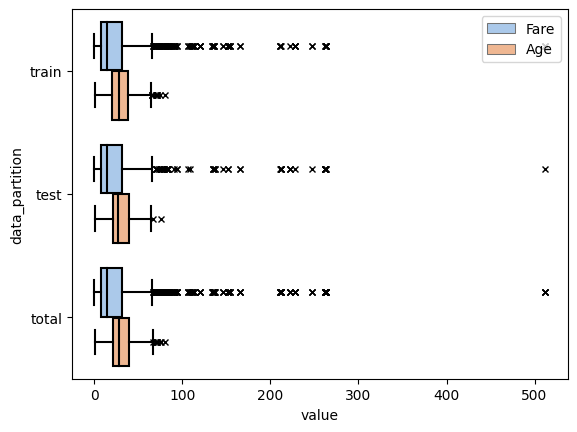

In [46]:
# titanic.boxplot_dist(["PassengerId", "Fare", "Age"], marker="x", orient="h", legend="upper right", dark_mode=DARK_MODE)
titanic.boxplot_dist(["Fare", "Age"], marker="x", orient="h", legend="upper right", dark_mode=DARK_MODE)

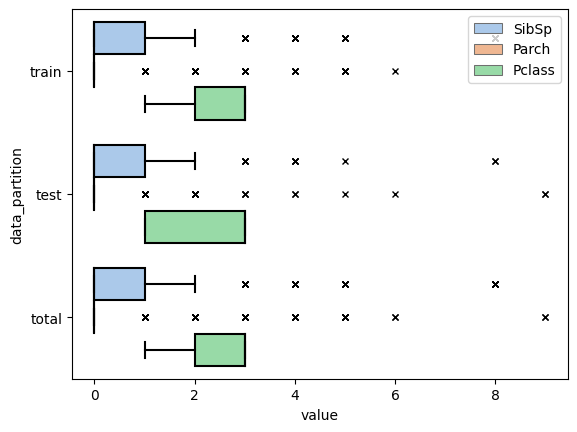

In [47]:
titanic.boxplot_dist(['Pclass', 'SibSp', 'Parch'], marker="x", orient="h", legend="upper right", dark_mode=DARK_MODE)

## Data Inputation

replace the NaN values of numerical features in training and test dataset

In [48]:
# train_X_raw_df.describe()
# test_X_raw_df.describe()
# all_X_raw_df.describe()

In [49]:
def filter_values(x):
    """x is tuple with two positions"""
    match x[0]:
        case "Age":
            return (x[0], round(x[1]))
        case "Fare":
            return (x[0], round(x[1], 4)) # returns float with rounded 4 decimals
        case _:
            return x   

In [50]:
train_X_raw_df, train_mean_dict = fill_missing_values_with_mean(
    df=train_X_raw_df, pop_df=all_X_raw_df, filter_cols=num_features, filter_func=filter_values)
print(train_mean_dict)
print(f"no. of numerical cols. has NaN values: {len(na_columns(train_X_raw_df, num_features))}")

{'Age': 30}
no. of numerical cols. has NaN values: 0


In [51]:
test_X_raw_df, test_mean_dict = fill_missing_values_with_mean(
    df=test_X_raw_df, pop_df=all_X_raw_df, filter_cols=num_features, filter_func=filter_values)
print(test_mean_dict)
print(f"no. of numerical cols. has NaN values: {len(na_columns(test_X_raw_df, num_features))}")


{'Age': 30, 'Fare': 33.2955}
no. of numerical cols. has NaN values: 0


## Examining the correlation of numerical features and labels

In [52]:
train_X_y_raw_df = pd.concat([train_X_raw_df, train_raw_y], axis=1)
threshold = 0.2
corr_df, high_corr_df = feature_correlation(train_X_y_raw_df, label=label_name, threshold=threshold)
corr_df


,PassengerId,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Survived
PassengerId,1.000000,-0.035144,0.033019,-0.057527,-0.001652,0.012658,-0.042939,0.042939,-0.005007
Pclass,-0.035144,1.000000,-0.329727,0.083081,0.018443,-0.549500,-0.131900,0.131900,-0.338481
Age,0.033019,-0.329727,1.000000,-0.232440,-0.180330,0.090632,-0.084660,0.084660,-0.070657
SibSp,-0.057527,0.083081,-0.232440,1.000000,0.414838,0.159651,0.114631,-0.114631,-0.035322
Parch,-0.001652,0.018443,-0.180330,0.414838,1.000000,0.216225,0.245489,-0.245489,0.081629
Fare,0.012658,-0.549500,0.090632,0.159651,0.216225,1.000000,0.182333,-0.182333,0.257307
Sex_female,-0.042939,-0.131900,-0.084660,0.114631,0.245489,0.182333,1.000000,-1.000000,0.543351
Sex_male,0.042939,0.131900,0.084660,-0.114631,-0.245489,-0.182333,-1.000000,1.000000,-0.543351
Survived,-0.005007,-0.338481,-0.070657,-0.035322,0.081629,0.257307,0.543351,-0.543351,1.000000


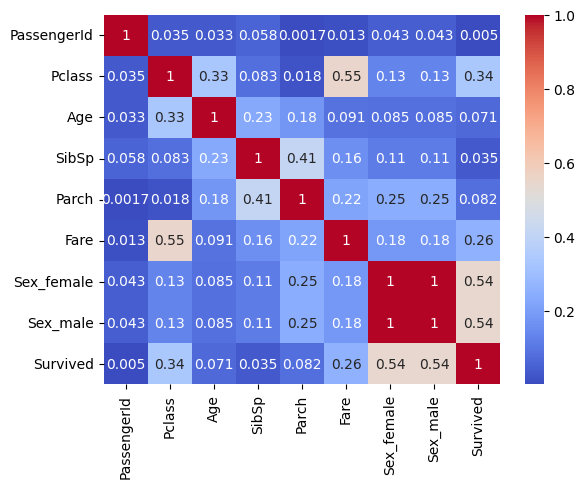

In [53]:
visual_helper.display_feature_correlation(corr_df=corr_df)

In [54]:
# display the features with high correlation to the label
high_corr_df

,Survived
Pclass,-0.338481
Fare,0.257307
Sex_female,0.543351
Sex_male,-0.543351
Survived,1.000000


## Select features

In [55]:
# select only numerical features
selected_features = num_features.copy()
selected_features.remove("PassengerId")

In [56]:
# split the training data
X_train, X_valid, y_train, y_valid = titanic.split(
    titanic.select_cols(df=train_X_raw_df, cols=selected_features), 
    train_raw_y, test_size=0.2, random_state=10)

## Algo factory for building different models

In [57]:
from typing import Any
class AlgoML:
    """Interface"""
    def train_model(self, X_train, y_train) -> Any:
        pass

class AlgoXgboost(AlgoML):
    def train_model(self, X_train, y_train) -> Any:
        # shift + tab to unindent multiple lines 
        param_grid = {
            'n_estimators': range(6, 10),
            'max_depth' : range(3, 8),
            'learning_rate' : [.2, .3, .4],
            'colsample_bytree' : [.7, .8, .9, 1]
        }

        xgb = XGBClassifier()
        # Searching for the best parameters
        g_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=3, n_jobs=1, verbose=0, return_train_score=True)

        # Fitting the model using best parameters found
        g_search.fit(X_train, y_train)

        # print the best parameters found
        print(g_search.best_params_)
        # valid 
        # g_search.score(X_valid, y_valid)
        model = g_search
        return model
    
class AlgoCustom(AlgoML):
    def train_model(self, X_train, y_train) -> Any:
        feature_position = ProbBinaryClassifier.feature_position(X_train, "Sex_female")
        # config model
        model = ProbBinaryClassifier(feature_position, 1)
        # Train model
        model.fit(X_train, y_train)
        return model
    

class AlgoFactory:
    def get_algo(algo: str) -> AlgoML:
        if algo == "xgboost":
            return AlgoXgboost()
        else:
            return AlgoCustom()

## Traing a model 

* Xgboost model
* Custom model

In [58]:
algo = AlgoFactory.get_algo(algo=ALGO)
model = algo.train_model(X_train=X_train, y_train=y_train)
predicts = model.predict(X_valid)

{'colsample_bytree': 1, 'learning_rate': 0.4, 'max_depth': 3, 'n_estimators': 6}


## Model performance validation

In [59]:
validator = ModelValidator(y_valid, predicts, dark_mode=DARK_MODE)
scores_dict = validator.evaluate()
validator.print_eval_result(scores_dict)

## conf_mat_df:
          Perished  Survived
Perished       103        14
Survived        14        48

## conf_mat:
[[103  14]
 [ 14  48]]

## f1:
0.7741935483870968

## acc:
0.8435754189944135

## roc_fpr:
[0.         0.11965812 1.        ]

## roc_tpr:
[0.         0.77419355 1.        ]

## roc_thresholds:
[2 1 0]

## auc:
0.8272677143644885



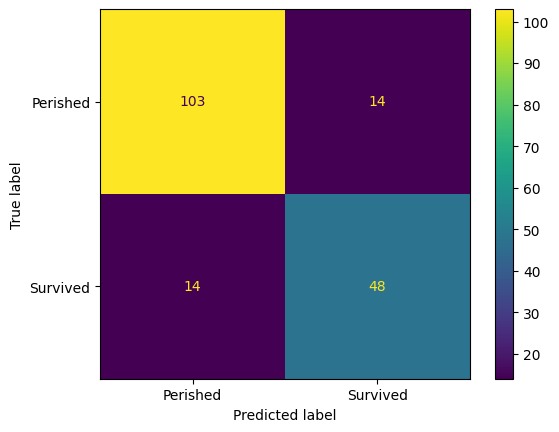

In [60]:
# 83 is false positive (false predicted to positive label, which has negative label as ground truth)
validator.display_confusion_matrix()

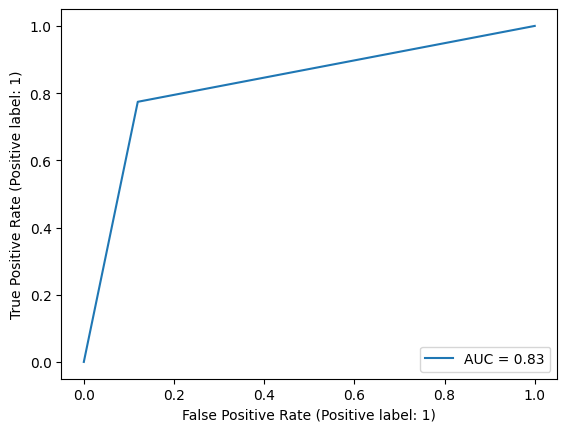

In [61]:
# ROC: Receiver operating characteristic
# AUC -> 1
validator.display_roc_curve()

## Model input feature attribution

In [62]:
# Create Explainer callable for X_valid data set
if KERNEL_EXPLAINER:
    explainer = ModelKernelExplainer(model=model, train_data=X_train, inference_data=X_valid, dark_mode=DARK_MODE, link=LINK)
else: 
    explainer = ModelExplainer(model=model, data=X_valid, dark_mode=DARK_MODE)


Using 712 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/179 [00:00<?, ?it/s]

In [63]:
@ModelExplainer.valid_index
def get_details(df: DataFrame, idx: int, org_df: DataFrame) -> DataFrame:
    """get the passenger info from the original data frame based on the index position of validation set
    @param df: 
    @param idx: index position, this must be idx so that decorator works
    """
    # get the index name from the original raw dataset, from the index position of validation data set
    index_name = df.iloc[idx].name
    # use slicing on the same index name to get the passenger info as a DataFrame obj
    return org_df.loc[index_name: index_name]

## Base values in SHAP
Following the [SHAP paper](https://proceedings.neurips.cc/paper_files/paper/2017/file/8a20a8621978632d76c43dfd28b67767-Paper.pdf):

the base value $E[f(z)]$ is "the value that would be predicted if we did not know any features from the current output". 

In other words, it is the mean of model prediction using our `background` or `reference` dataset: `X_train`
```python3
ModelKernelExplainer(model=model, train_data=X_train, ...)
```
the base value $E[f(z)]$:
```python3
base_value = np.mean(
    model.predict_proba(X_train),
    axis=0
)
```

Note: 
* The kernelShap with `Link="identity"` output the shap value in `probability` unit space
* The kernelShap with `Link="logit"` output the shap value in `log(odd)` unit space, which is more evenly distributed for loss and gains in a linear scale.

Logit funciton $log(\frac{p_x}{1 - p_x}) = log(p_x) - log(1 - p_x)$, `np.log()` uses natural logarithm as base.



In [64]:
from typing import Iterable
def simple_logit(probs: Iterable):
    # assumption all the probability in the Iterable shall be 1
    return np.array([ np.log(x) - np.log(1-x) for x in probs])

if getattr(explainer.explainer, "expected_value", None) is not None:
    # print(explainer.explainer.expected_value)
    print(f"shap base value: \n{explainer.explainer.expected_value}")

    # calculate base value for kernelshap with link identity and logit output space mapper
    # average of all the local data predictions, X_train
    all_local_data_predictions = model.predict_proba(X_train)
    base_value = np.mean(all_local_data_predictions, axis=0)
    if (LINK == 'logit'):
        base_value = simple_logit(base_value)
    print(f"base value from local data predictions: \n{base_value}")
else:
    print("no expected_value in explainer")    

shap base value: 
[ 0.40749675 -0.40749678]
base value from local data predictions: 
[ 0.40749663 -0.40749654]


In [65]:
# examining the shap_values, as Explaination or List, Array from kernelExplainer
# explainer.shap_values

In [66]:
# shap.initjs()
# shap.plots.force(explainer.explainer.expected_value[1], 
#                  explainer.shap_values[1], explainer.data, link="identity")
# shap.plots.force(explainer.explainer.expected_value[1], explainer.shap_values[1][0], explainer.data.iloc[0], link="identity")
# shap.plots.force(explainer.explainer.expected_value[0], explainer.shap_values[0][0], explainer.data.iloc[0], link="identity")

     PassengerId  Pclass                  Name   Age  SibSp  Parch             Ticket   Fare Cabin Embarked  Sex_female  Sex_male  Survived
590          591       3  Rintamaki, Mr. Matti  35.0      0      0  STON/O 2. 3101273  7.125   NaN        S           0         1         0

predicted probability for label 0 == Perisched


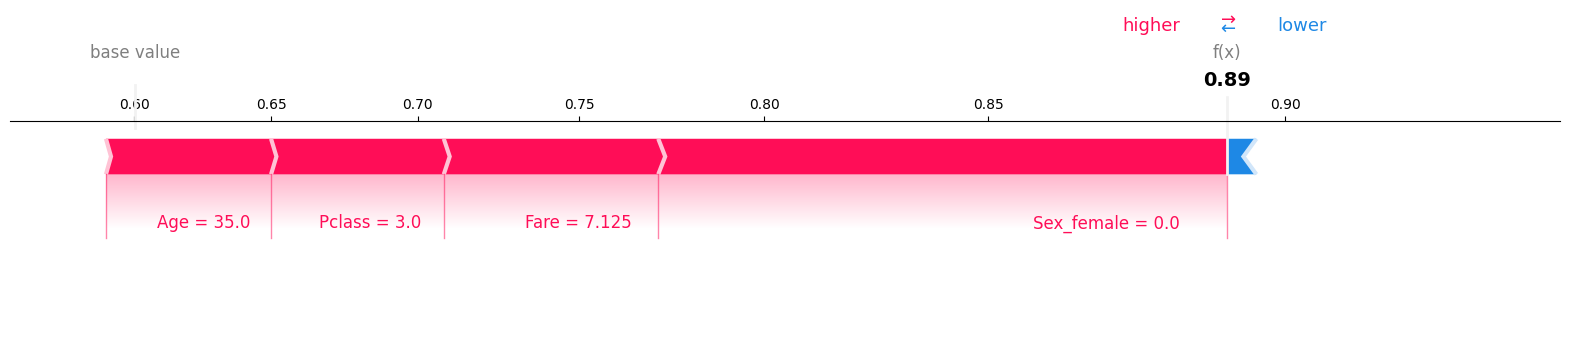


predicted probability for label 1 == Survived


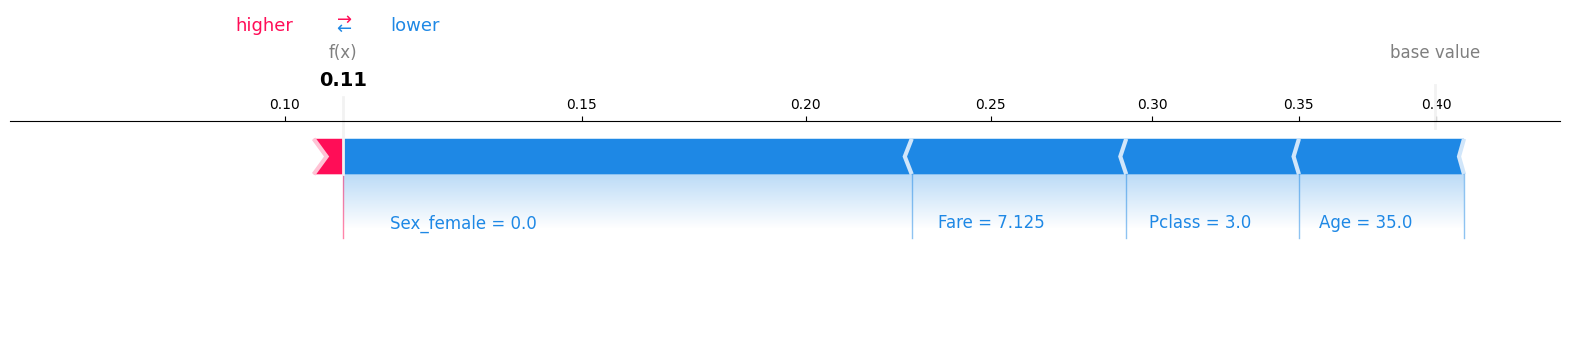

In [67]:
# Pclass = 3.0 doesn't play any rules for our passenger at X_valid dataset with rank pos 0
idx_pos = 0
passager_df = get_details(df=X_valid, idx=idx_pos, org_df = train_X_y_raw_df)
print(passager_df)
explainer.force_plot(idx = idx_pos)
explainer.waterfall_plot(idx = idx_pos)

     PassengerId  Pclass                        Name  Age  SibSp  Parch     Ticket    Fare Cabin Embarked  Sex_female  Sex_male  Survived
788          789       3  Dean, Master. Bertram Vere  1.0      1      2  C.A. 2315  20.575   NaN        S           0         1         1

predicted probability for label 0 == Perisched


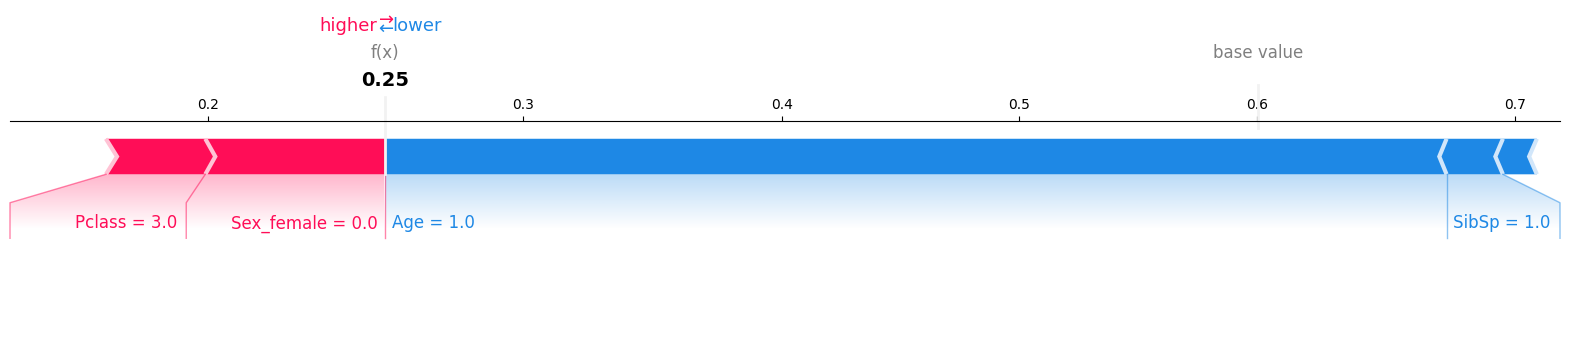


predicted probability for label 1 == Survived


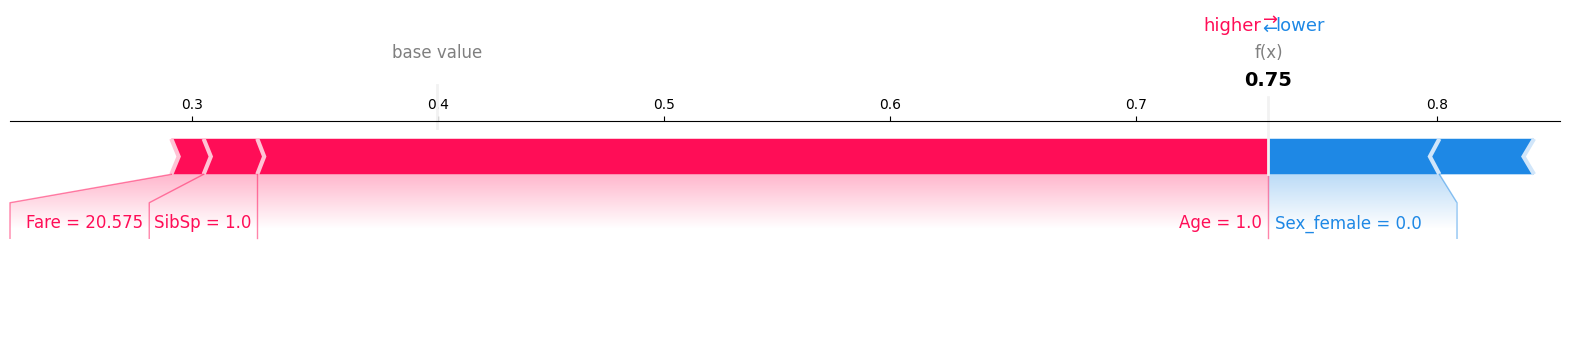

In [68]:
# Pclass = 3.0 doesn't play any rules for our passenger at X_valid dataset with rank pos 100
idx_pos = 100
passager_df = get_details(df=X_valid, idx=idx_pos, org_df = train_X_y_raw_df)
print(passager_df)
explainer.force_plot(idx = idx_pos)
explainer.waterfall_plot(idx = idx_pos)

In [69]:
# idx_pos = 178
# passager_df = get_details(df=X_valid, idx=idx_pos, org_df = train_X_raw_df)
# print(passager_df)
# explainer.force_plot(idx = idx_pos)

In [70]:
# summary_plot is a wrapper of beeswarm_plot(), kernel shap has no beeswarm_plot
explainer.beeswarm_plot()

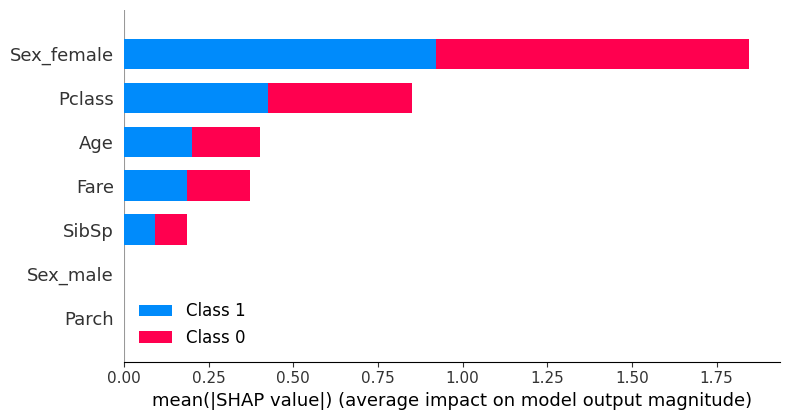

In [71]:
explainer.summary_plot()


predicted probability for label 1 == Survived


auto_interact_features is ignored.


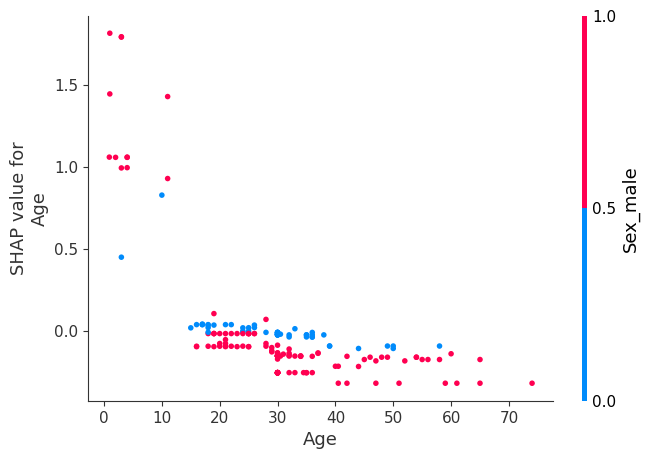

In [72]:
explainer.scatter_plot(feature="Age", auto_interact_features=1)


predicted probability for label 1 == Survived


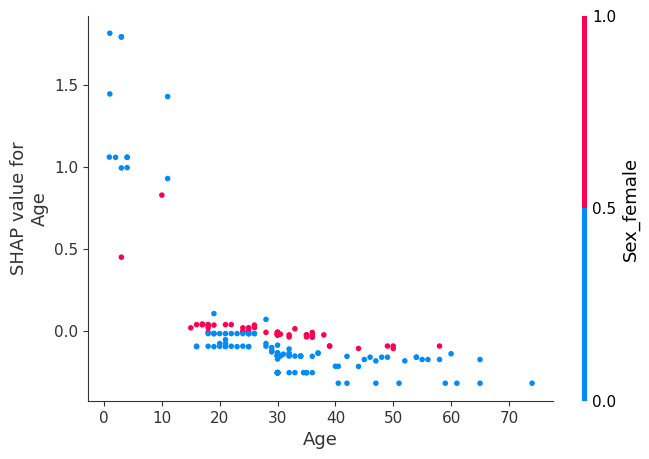

In [73]:
explainer.scatter_plot(feature="Age", interact_feature="Sex_female")


predicted probability for label 1 == Survived


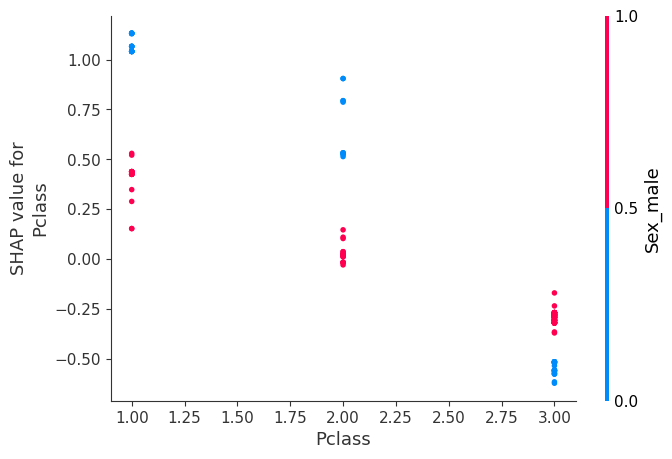

In [74]:
explainer.scatter_plot(feature="Pclass")

### Play ground: Naiv gender based approach

In [75]:
"""Naiv gender based approach"""
X_y_train = pd.concat([X_train, y_train], axis=1)

# women = train_X_y_raw_df.loc[train_X_y_raw_df["Sex_female"] == 1]["Survived"]
# rate_women = sum(women) / len(women)

def survived_rate(df: DataFrame, feature_name="Sex_female", feature_value=1, label_name="Survived"):
    label_part = df.loc[df[feature_name] == feature_value][label_name]
    return sum(label_part) / len(label_part)

rate_women = survived_rate(X_y_train, "Sex_female")
print(f"% of women who survied: {rate_women:.2%}")

rate_men = survived_rate(X_y_train, "Sex_male")
print(f"% of men who survied: {rate_men:.2%}")

% of women who survied: 73.64%
% of men who survied: 19.82%


### Play ground: kernel shap
uncomment the following comments to play arround with shap.KernelExplainer to calculate the shap value estimate Shapley value

In [76]:
# my_kernel_explainer = shap.KernelExplainer(model=model.predict_proba, data=X_train.to_numpy(), link=LINK, algorithm="kernel")

In [77]:
# my_shap_values = my_kernel_explainer.shap_values(X_valid.iloc[[0]].to_numpy(), nsamples="auto")